# RGI09 (Russian Arctic)

F. Maussion & S. Galos

Same outlines as in RGI6, with a small correction of ice divides

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, find_duplicates, correct_geoms
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 9

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '09_rgi60_RussianArctic.zip')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
567,1069,51591.5,Moholdt,Koenig,2013,"Svalbard, Jan Mayen, and Bouvet",2002,2000,2010
671,1474,22390.1,Paul,Paul,2017,Various (GlobGlacier),2016,2013,2016
694,1510,12370.7,"Paul, Rastner, Schaub",Paul,2018,Various (GlobGlacier),2016,2016,2016
759,3,841.8,Kochtitzky,Kochtitzky,2021,"Coropuna, Peru",2000,2000,2000


In [5]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

In [6]:
# For this region RGI07 shall be equal to RGI06 so...
#...extract RGI06 from GLIMS by 'subm_id' 567 which refers to data by Moholdt et al. 2012
s_567 = shp.loc[shp['subm_id']== 567].copy()
s_567['is_rgi6'] = True

In [7]:
s_759 = shp.loc[shp['subm_id']== 759].copy()
s_759['is_rgi6'] = False

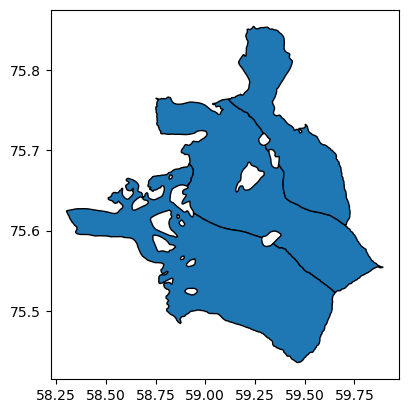

In [8]:
s_759.plot(edgecolor='k');

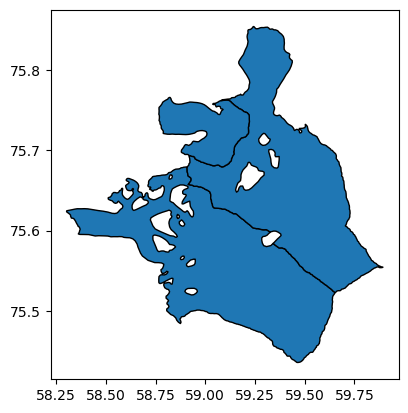

In [9]:
# Remove the three ids that need to be replaced in GLIMS
to_replace = ['G059108E75722N', 'G059314E75523N', 'G059401E75657N']
sel = s_567.loc[s_567['glac_id'].isin(to_replace)]
sel.plot(edgecolor='k');

There is some area difference but it's ok it's Will: 

In [10]:
area_diff = (s_759['area'].sum() - sel['area'].sum())
area_diff

3500380.3191224337

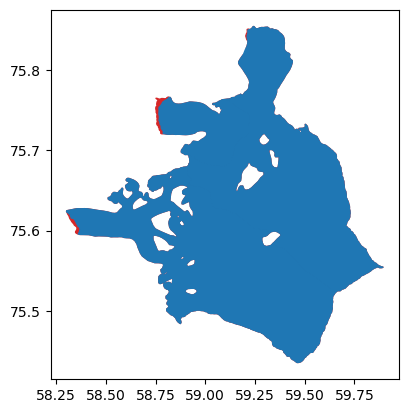

In [11]:
ax = s_759.plot(color='C3', edgecolor='C3');
ax = sel.plot(ax=ax, edgecolor='C0');

In [12]:
s_567 = s_567.loc[~ s_567['glac_id'].isin(to_replace)].copy()

In [13]:
s_567.geog_area.iloc[0]

'Svalbard, Jan Mayen, and Bouvet'

In [14]:
s_759['geog_area'] = s_567.geog_area.iloc[0]

In [15]:
rgi7 = pd.concat([s_567, s_759])

### Some sanity checks 

In [16]:
dupes = find_duplicates(rgi7)

Seems Okay!


In [17]:
rgi7 = correct_geoms(rgi7)

Found 1 invalid geometries out of 1069. Correcting...
After correction, 0 geometries are still invalid.
Area changed by -0.3 m2 (-0.0000%)


In [18]:
needs_size_filter(rgi7)

False

In [19]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
567,1066,1066
759,3,3


In [20]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

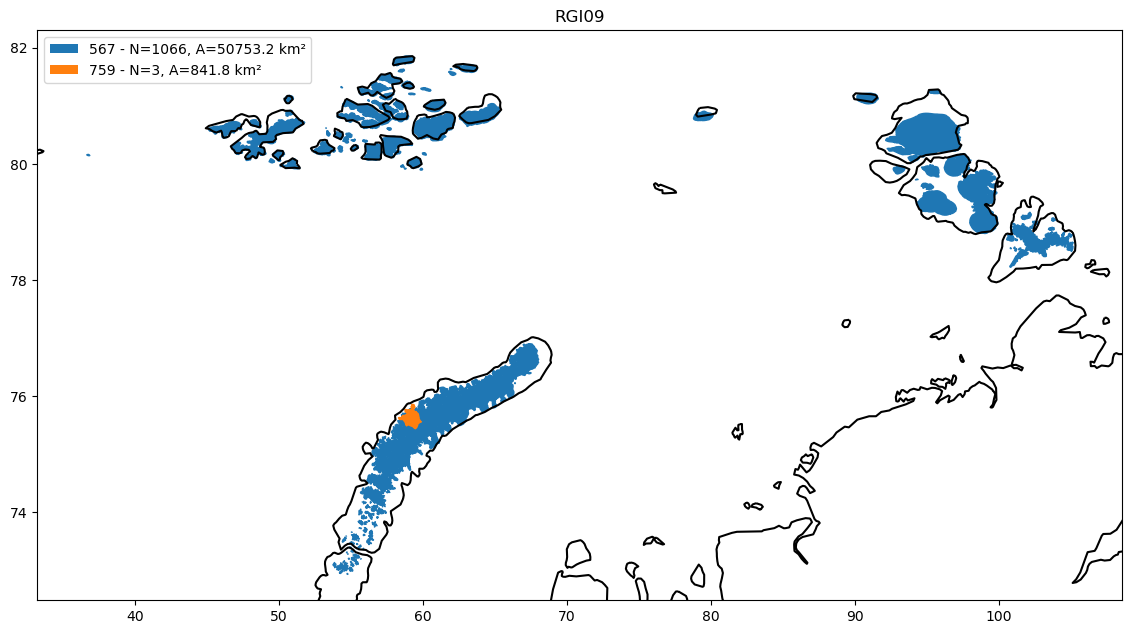

In [21]:
plot_map(rgi7, reg, loc='upper left')

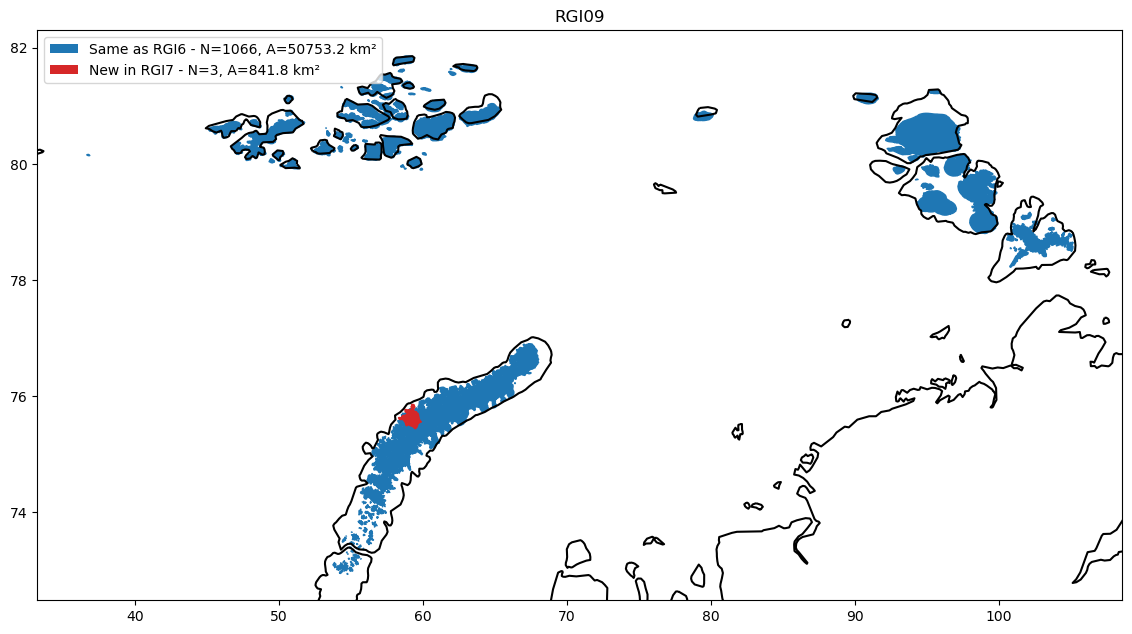

In [22]:
plot_map(rgi7, reg, loc='upper left', is_rgi6=True)

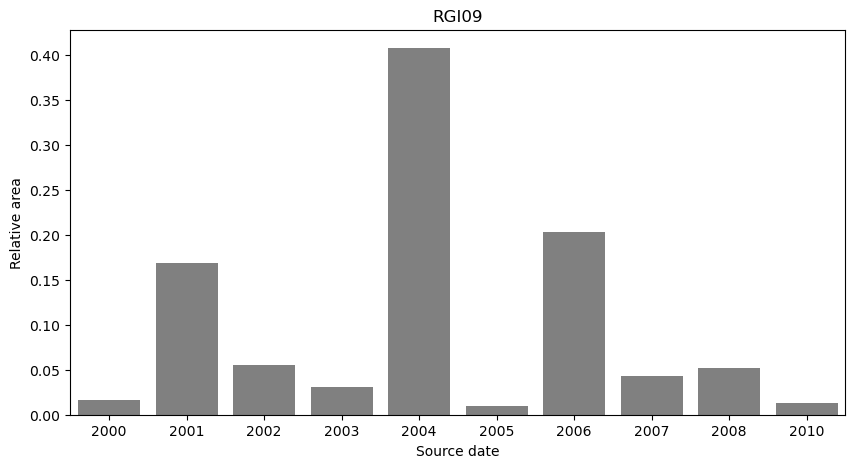

In [23]:
plot_date_hist(rgi7, reg)

### Text for github

In [24]:
fgh = sdf.T
fgh

subm_id,567,759
N,1066,3
A,50753.2,841.8
analysts,Moholdt,Kochtitzky
submitters,Koenig,Kochtitzky
release_date,2013,2021
geog_area,"Svalbard, Jan Mayen, and Bouvet","Svalbard, Jan Mayen, and Bouvet"
src_date_mode,2002,2000
src_date_min,2000,2000
src_date_max,2010,2000


In [25]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 567                             | 759                             |
|:--------------|:--------------------------------|:--------------------------------|
| N             | 1066                            | 3                               |
| A             | 50753.2                         | 841.8                           |
| analysts      | Moholdt                         | Kochtitzky                      |
| submitters    | Koenig                          | Kochtitzky                      |
| release_date  | 2013                            | 2021                            |
| geog_area     | Svalbard, Jan Mayen, and Bouvet | Svalbard, Jan Mayen, and Bouvet |
| src_date_mode | 2002                            | 2000                            |
| src_date_min  | 2000                            | 2000                            |
| src_date_max  | 2010                            | 2000                            |


## Write out and tar 

In [26]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI09/
RGI09/RGI09.shp
RGI09/RGI09.dbf
RGI09/RGI09.cpg
RGI09/RGI09.prj
RGI09/RGI09.shx
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI09.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI09'], returncode=0)


## Consistency check with RGI6 

In [24]:
# load reference data
from utils import open_zip_shapefile
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [25]:
len(rgi7), len(rgi6)

(1069, 1069)

Test the areas:

In [26]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area 
rgi7['area'] = rgi7.to_crs({'proj':'cea'}).area 

In [27]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['Area'].sum())
print('Area RGI6 computed by us (km2)', rgi6['area'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['area'].sum() + area_diff - rgi7['area'].sum()) * 1e-6)

Area RGI7a (km2) 51595.02461052788
Area RGI6 (km2) 51591.6
Area RGI6 computed by us (km2) 51591.525007073666
diff areas RGI6 - RGI7 computed by us (km2) 0.0007768649139404297


The number of individual gaciers is the same! The total areas differ by only 777 m²...what else do we want?!